# Analysis and demeaning using complete weekly/daily dataset

In [1]:
import os
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

### Set up cluster
Use Dask's `job-queue` to process all jobs in the cluster. Check `~/.config/dask/jobqueue.yaml` file to set cluster configuration. Check `cluster.job_script()` text to explore the file configfuration. 

In [179]:
cluster = SLURMCluster()
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=5
#SBATCH --mem=19G
#SBATCH -t 00:30:00
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/home/ivanhigueram/.conda/envs/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.220.71:38774 --nthreads 5 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --interface ib0



In [180]:
client = Client(cluster)
client

Client Scheduler: tcp://172.25.220.71:38774 Dashboard: http://172.25.220.71:42149/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [181]:
cluster.scale(10)

In [187]:
client

Client Scheduler: tcp://172.25.220.71:38774 Dashboard: http://172.25.220.71:42149/status,Cluster Workers: 10 Cores: 50 Memory: 200.00 GB


### Or test code in nodes if you are in `sinteractive`

If you don't want to submit jobs, or simply want to checkout some fast computation, you can call the client within the log-in node. This way will give you all the log-in node resources to parallel operations

**WARNING**: System administrators do not like users running heavy computations in cluster. 

In [23]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45057")
client

Client Scheduler: tcp://127.0.0.1:45057 Dashboard: http://127.0.0.1:46233/status,Cluster Workers: 8 Cores: 56 Memory: 269.63 GB


# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product. Instead of reshaping (or re-indexing) our data, we will extract the pure values and use `pandas` to pivot everything.

In [188]:
xarray_data = xr.open_dataset('/project2/geos39650/jet_stream/data/df_lat_20_1W.nc',
                             chunks={'time': 1})
xarray_data

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 522)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-07 1980-12-14 ... 2018-03-04
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>

In [189]:
da_test_time_sample = xarray_data.sel(time=slice('2000-01-01', '2020-01-08'))
da_test_time_sample

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 258)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-02 2000-01-09 ... 2018-03-04
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 280, 1440), meta=np.ndarray>

In [190]:
t_df =  da_test_time_sample.to_dask_dataframe(dim_order=['time', 'latitude', 'longitude'])

In [191]:
t_df

,time,latitude,longitude,t2m
npartitions=258,,,,
0,datetime64[ns],float32,float32,float32
403200,...,...,...,...
...,...,...,...,...
103622400,...,...,...,...
104025599,...,...,...,...


## Test Dask magic by getting mean temperature per week and grid-cell

In [ ]:
t_df['woy'] = t_df.time.dt.week

In [ ]:
t_df_group = t_df.groupby(['latitude', 'longitude', 'woy']).t2m.mean()

In [ ]:
%%time
t_df_group.compute()

## Testing T' prime calculation with small dataset in Dask

Test only with 3 years with the weekly reanalysis ERAA-5. 

In [192]:
def calculate_area_from_latitude(latitude):

    R_EARTH = 6367.47 
    DPHI = 0.25*np.pi/180.0
    
    return (R_EARTH *DPHI)**2 * np.cos(np.deg2rad(latitude))


def area_calculation_real_area(dd_data,
                               cut_interval,
                               resample_time = False,
                               grouping_time_interval='1w',
                               temp_var='t2m'):
    """
    Area calculation using a Dask DataFrame
    
    dd_data: Dask dataframe with partitioned data
    cut_interval: integer defining size of temperature bins
    """
    
    R_EARTH = 6367.47 
    DPHI = 0.25*np.pi/180.0
    
    dd_data['area_grid'] = dd_data.latitude.map_partitions(
        calculate_area_from_latitude
    )
    
    if not 'temp_brakets' in dd_data.columns:
        t_max, t_min = dask.compute(dd_data[temp_var].max(), dd_data[temp_var].min())
        range_cuts = range(int(t_min), int(t_max) + 10 , cut_interval)
    
        dd_data['temp_bracket'] = dd_data[temp_var].map_partitions(
            pd.cut, range_cuts
        )

    # Grouper by time: 2 weeks 
    if resample_time:
        group_time = pd.Grouper(key='time', 
                                freq=grouping_time_interval)
        dd_data_group = dd_data.groupby(['temp_bracket', group_time])
    else:
        dd_data_group = dd_data.groupby(['temp_bracket', 'time'])
    
    # Group by data
    dd_data_group = dd_data_group.\
    area_grid.\
    sum().\
    compute()
    
    #Cumumlative sum
    dd_data_group_time = dd_data_group.groupby(level=[1]).cumsum()
    
    
    return dd_data_group_time



def dists_of_lat_eff(cdf_areas):
    """
    Calculate distribution of Effective Latitudes
    
    This is an intermediate step to calculate both Tref and T_prime
    """
    R_EARTH = 6367.47 
    DPHI = 0.25*np.pi/180.0
    
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_EARTH**2))
    pdf_lat_effs_deg = np.rad2deg(pdf_lat_effs)
    
    return pdf_lat_effs



def temp_ref(ddf,
             area_weights,
             temp_binedges,
             pdf_lat_effs):
    """
    Pandas calculation of the temperature refence 
    
    Take a lat point and calculate T_ref with just the latitude
    given the effective lat vs temp contour relation
    
    """
    
    # Avoid problems with merge
    ddf['temp_bracket'] = ddf.temp_bracket.apply(lambda x: x.left.astype(int))
    
    ddf_merge = ddf.merge(area_weights,
                          on=['time', 'temp_bracket'],
                         how='left')
    
    # Interpolate to calculate the t_ref latitde mapping
    t_ref =  np.interp(ddf_merge.latitude,
                       np.flip(ddf_merge[pdf_lat_effs]),
                       np.flip(ddf_merge[temp_binedges])
                      )

    return t_ref



def T_prime(dd_data, 
            temp_var='t2m',
            resample_time=True,
            grouping_time_interval='2w',
            build_buckets=True,
            cut_interval=2,
            all_series=True,
            max_min=None):
    """
    Calculate T'prime
    """
    
    # Calculate binned temperature using all series min, max
    if all_series:
        t_max, t_min = dask.compute(dd_data[temp_var].max(), dd_data[temp_var].min())
        range_cuts = range(int(t_min), int(t_max) + 10, cut_interval)
    else: 
        t_max, t_min = max_min
        range_cuts = range(int(t_min), int(t_max) + 10, cut_interval)
        
        
    # Calculate temperature brackets
    dd_data['temp_bracket'] = dd_data[temp_var].map_partitions(
        pd.cut, range_cuts
    )
    
    # Calculate area weights
    area_weights = area_calculation_real_area(dd_data=dd_data,
                                              resample_time=False,
                                              cut_interval=cut_interval,
                                              grouping_time_interval='1w')
    
    # Calculate effective latitudes by using the temperature area weights
    area_weights = area_weights.reset_index(drop=False)
    
    area_weights['cdf_eff_lat_mapping'] = area_weights.groupby('time').\
    area_grid.apply(lambda x: dists_of_lat_eff(x))
    
    area_weights['temp_bracket'] = area_weights.temp_bracket.apply(lambda x: x.left.astype(int)).astype(int)
    area_weights['eff_lat_deg'] = np.rad2deg(area_weights.cdf_eff_lat_mapping)
    
    # Merge and calculate t_ref by time partition
    test_p = dd_data.map_partitions(temp_ref,
                                    area_weights=area_weights,
                                    temp_binedges='temp_bracket',
                                    pdf_lat_effs='eff_lat_deg',
                                    meta={'t_ref': float})
    
    # Assign temperature referece to main dataframe and calculate t_prime
    dd_data['tref'] = pd.Series(test_p.compute())
    dd_data['t_prime'] = dd_data['t2m'] - dd_data['tref']
    
    return dd_data


def dask_data_to_xarray(df,
                        dims,
                        shape=None,
                        path=None,
                        target_variable='t2m'):
    
    var_array = df[target_variable].values
    var_array.compute_chunk_sizes()
    
    if shape is None:
        shape = tuple([len(df[dim].unique()) for dim in dims])
        
    var_array_reshape = var_array.reshape(shape)
    
    dims_values = [df[dim].unique() for dim in dims]
    coords_dict = dict(zip(dims, dims_values))
    
    xarr = xr.DataArray(var_array_reshape.compute(),
                        dims = dims,
                        coords = coords_dict
                       )
    return xarr


In [193]:
test_ultimate = T_prime(t_df)

In [194]:
test_ultimate

,time,latitude,longitude,t2m,temp_bracket,area_grid,tref,t_prime
npartitions=258,,,,,,,,
0,datetime64[ns],float32,float32,float32,category[known],float32,float64,float64
403200,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
103622400,...,...,...,...,...,...,...,...
104025599,...,...,...,...,...,...,...,...


In [196]:
t_ref_test = dask_data_to_xarray(df=test_ultimate,
                             dims=['time', 'latitude', 'longitude'],
                             target_variable='t_prime')

In [201]:
t_ref_test

<xarray.DataArray (time: 258, latitude: 280, longitude: 1440)>
array([[[ 4.91699219e-01,  4.91699219e-01,  4.91699219e-01, ...,
          4.91699219e-01,  4.91699219e-01,  4.91699219e-01],
        [ 5.42144775e-01,  5.43060303e-01,  5.44342041e-01, ...,
          5.39978027e-01,  5.40557861e-01,  5.41229248e-01],
        [ 6.88507080e-01,  6.91040039e-01,  6.93145752e-01, ...,
          6.84234619e-01,  6.85607910e-01,  6.86981201e-01],
        ...,
        [-4.10583496e-01, -5.02441406e-01, -5.66955566e-01, ...,
         -1.05209351e+00, -6.60217285e-01, -3.66027832e-01],
        [-1.07116699e-01, -2.00286865e-01, -1.56250000e-02, ...,
         -6.39129639e-01, -3.28369141e-01, -7.41577148e-02],
        [ 6.20422363e-02, -1.40380859e-03,  3.61968994e-01, ...,
         -2.46917725e-01, -2.11639404e-01,  2.16674805e-03]],

       [[ 1.15429688e+00,  1.15429688e+00,  1.15429688e+00, ...,
          1.15429688e+00,  1.15429688e+00,  1.15429688e+00],
        [ 1.35894775e+00,  1.35827637e+00,  1.35723877e+00, ...,
          1.36126709e+00,  1.36065674e+00,  1.36001587e+00],
        [ 1.56912231e+00,  1.56765747e+00,  1.56576538e+00, ...,
          1.57376099e+00,  1.57180786e+00,  1.57040405e+00],
        ...,
        [ 9.63073730e-01,  8.15093994e-01,  8.26171875e-01, ...,
          4.37927246e-01,  8.23181152e-01,  1.03427124e+00],
        [ 1.08926392e+00,  1.01248169e+00,  1.10287476e+00, ...,
          8.40362549e-01,  1.12985229e+00,  1.24862671e+00],
        [ 1.00741577e+00,  1.11657715e+00,  1.29815674e+00, ...,
          1.23294067e+00,  1.18652344e+00,  1.25878906e+00]],

       [[ 5.43914795e-01,  5.43914795e-01,  5.43914795e-01, ...,
          5.43914795e-01,  5.43914795e-01,  5.43914795e-01],
        [ 5.78887939e-01,  5.78414917e-01,  5.77499390e-01, ...,
          5.81771851e-01,  5.80825806e-01,  5.79833984e-01],
        [ 6.90261841e-01,  6.88552856e-01,  6.87026978e-01, ...,
          6.95449829e-01,  6.93847656e-01,  6.91879272e-01],
        ...,
        [ 1.06506348e+00,  1.00689697e+00,  1.04946899e+00, ...,
         -3.34075928e-01,  2.42675781e-01,  7.72216797e-01],
        [ 1.18685913e+00,  1.38815308e+00,  1.67010498e+00, ...,
         -1.85089111e-01,  2.95318604e-01,  8.32489014e-01],
        [ 1.38397217e+00,  1.98175049e+00,  2.39178467e+00, ...,
          2.95745850e-01,  5.29937744e-01,  1.06207275e+00]],

       ...,

       [[ 1.02737427e-01,  1.02737427e-01,  1.02737427e-01, ...,
          1.02737427e-01,  1.02737427e-01,  1.02737427e-01],
        [ 5.75210571e-01,  5.76492310e-01,  5.76934814e-01, ...,
          5.73471069e-01,  5.74386597e-01,  5.74859619e-01],
        [ 1.12782288e+00,  1.12905884e+00,  1.12965393e+00, ...,
          1.12426758e+00,  1.12561035e+00,  1.12712097e+00],
        ...,
        [ 6.98028564e-01,  5.17364502e-01,  4.43054199e-01, ...,
          6.47033691e-01,  8.26690674e-01,  8.55010986e-01],
        [ 1.10894775e+00,  9.76776123e-01,  1.07226562e+00, ...,
          1.10766602e+00,  1.20523071e+00,  1.25439453e+00],
        [ 1.43402100e+00,  1.45718384e+00,  1.67312622e+00, ...,
          1.64102173e+00,  1.47219849e+00,  1.52398682e+00]],

       [[ 1.26556396e-01,  1.26556396e-01,  1.26556396e-01, ...,
          1.26556396e-01,  1.26556396e-01,  1.26556396e-01],
        [ 4.23675537e-01,  4.23889160e-01,  4.23522949e-01, ...,
          4.23553467e-01,  4.23339844e-01,  4.23675537e-01],
        [ 6.89575195e-01,  6.88537598e-01,  6.87835693e-01, ...,
          6.90277100e-01,  6.90399170e-01,  6.90277100e-01],
        ...,
        [-3.05314691e-01, -3.82341058e-01, -3.63877924e-01, ...,
         -2.00639398e-01, -4.64951111e-02, -2.50412537e-02],
        [ 7.59887695e-02,  8.71276855e-02,  2.53570557e-01, ...,
          1.70349121e-01,  2.82226562e-01,  3.20953369e-01],
        [ 5.55389404e-01,  7.15270996e-01,  9.84619141e-01, ...,
          7.70172119e-01,  6.73309326e-01,  6.99920654e-01]],

       [[ 1.82147217e+00,  1.82147217e+00,  1.82147217e+00, ...,
    

In [198]:
t_ref_test.to_netcdf('test_t_ref_real_real.nc4')

In [24]:
t_ref_test = xr.open_dataarray('test_t_ref_real_real.nc4', chunks={'time':1})
t_ref_test

<xarray.DataArray (time: 258, latitude: 280, longitude: 1440)>
dask.array<open_dataset-ab6883635cbb447f06ce762cb0135b01__xarray_dataarray_variable__, shape=(258, 280, 1440), dtype=float64, chunksize=(1, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-02 2000-01-09 ... 2018-03-04
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75

In [25]:
def globe_plots(xarr,titlestr="",contour=False,contours=None,savetitle=None):
    #set up the axes for a globe
    plt.subplots(figsize = (10, 10))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    #coolcool now we can plot it
    
    if contour:
        if contours is None:
            contours=range(int(xarr.min()),int(xarr.max()),10)
        xarr.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=contours,
                           center=0,
                           cbar_kwargs={'orientation': 'horizontal',
                                    'pad': 0.05,
                                    'shrink': 0.5,
                                    'ticks':contours}
                                       )
    else:
        xarr.plot(ax=ax, transform=ccrs.PlateCarree())
        
    ax.set_title(titlestr)
    #make it draw the pretty continents
    ax.set_global(); ax.coastlines();
    #draw lat-lon isocontours
    ax.gridlines()
    ax.plot()
    if savetitle is None:
        plt.show()
    else:
        plt.savefig('./figs/'+savetitle+'.png')

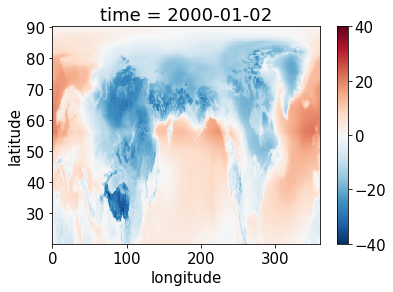

In [22]:
test_week.plot()

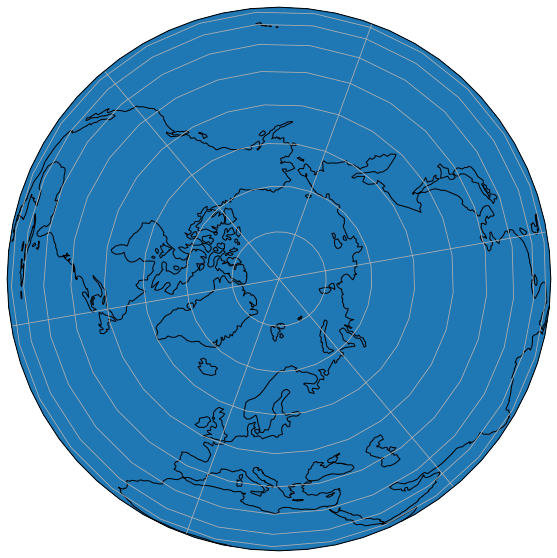

In [21]:
test_week = t_ref_test.sel(time=slice('2000-01-01', '2000-01-08'))
globe_plots(t_ref_test)

In [26]:
test_demean = t_ref_test.sel(time=slice('2000-01-01', '2010-12-31'))
means_y = test_demean.resample(time='10Y').mean().compute()

In [27]:
test_demean_demean = t_ref_test - means_y.isel(time=1)

In [28]:
test_demean_demean

<xarray.DataArray (time: 258, latitude: 280, longitude: 1440)>
dask.array<sub, shape=(258, 280, 1440), dtype=float64, chunksize=(1, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2000-01-02 2000-01-09 ... 2018-03-04
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75

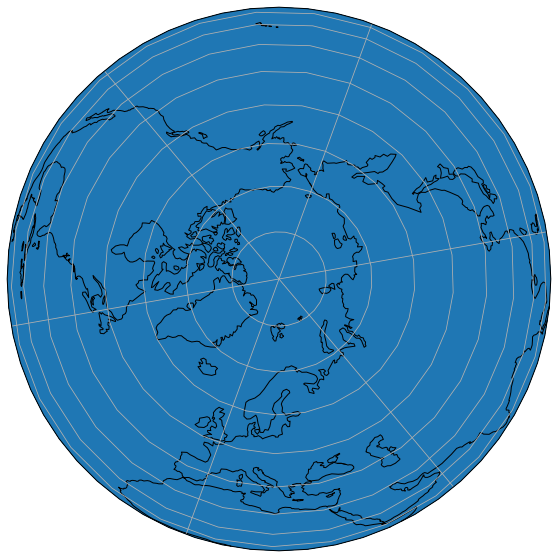

In [29]:
test_week = test_demean_demean.sel(time=slice('2008-01-01', '2008-01-07'))
globe_plots(test_demean_demean)

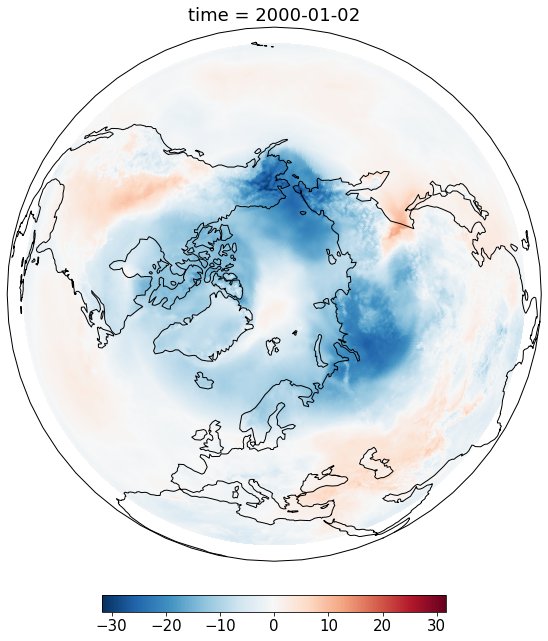

In [35]:
fig = plt.subplots(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(20, 90))
test_demean_demean.isel(time=0).plot.pcolormesh(ax=ax,
                                      cmap='RdBu_r',
                                      #vmax=int(test_demean_demean.max()),
                                      #vmin=int(test_demean_demean.min()),
                                      center=0,
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )
plt.tight_layout()
ax.set_global()
ax.coastlines()

In [37]:
for day in range(len(test_demean_demean.time.data)):
    print(day)
    fig = plt.subplots(figsize=(10, 10))
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    test_demean_demean.isel(time=day).plot.pcolormesh(ax=ax,
                                          cmap='RdBu_r',
                                          #vmax=int(t_test.max()),
                                          #vmin=int(t_test.min()),
                                          center=0.0,
                                          transform=ccrs.PlateCarree(),
                                          extend='neither',
                                          cbar_kwargs={'orientation': 'horizontal',
                                                      'pad': 0.05,
                                                      'shrink': 0.5,
                                                      'spacing': 'proportional'
                                                     }
                             )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f't_prime_decades_polar_div_{str(day).zfill(3)}.png')
    plt.clf()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


21


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


22


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


23


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


24


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


25


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


26


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


27


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


28


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


29


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


30


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


31


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


32


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


33


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


34


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


35


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


36


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


37


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


38


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


39


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


40


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


41


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


42


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


43


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


44


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


45


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


46


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


47


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


48


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


49


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


50


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


51


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


52


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


53


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


54


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


55


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


56


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


57


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


58


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


59


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


60


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


61


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


62


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


63


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


64


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


65


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


66


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


67


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


68


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


69


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


70


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


71


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


72


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


73


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


74


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


75


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


76


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


77


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


78


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


79


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


80


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


81


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


82


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


83


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


84


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


85


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


86


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


87


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


88


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


89


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


90


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


91


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


92


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


93


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


94


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


95


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


96


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


97


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


98


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


99


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


100


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


101


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


102


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


103


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


104


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


105


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


106


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


107


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


108


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


109


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


110


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


111


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


112


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


113


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


114


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


115


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


116


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


117


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


118


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


119


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


120


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


121


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


122


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


123


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


124


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


125


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


126


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


127


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


128


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


129


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


130


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


131


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


132


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


133


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


134


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


135


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


136


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


137


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


138


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


139


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


140


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


141


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


142


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


143


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


144


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


145


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


146


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


147


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


148


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


149


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


150


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


151


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


152


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


153


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


154


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


155


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


156


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


157


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


158


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


159


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


160


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


161


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


162


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


163


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


164


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


165


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


166


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


167


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


168


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


169


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


170


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


171


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


172


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


173


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


174


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


175


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


176


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


177


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


178


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


179


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


180


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


181


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


182


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


183


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


184


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


185


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


186


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


187


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


188


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


189


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


190


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


191


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


192


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


193


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


194


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


195


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


196


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


197


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


198


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


199


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


200


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


201


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


202


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


203


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


204


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


205


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


206


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


207


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


208


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


209


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


210


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


211


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


212


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


213


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


214


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


215


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


216


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


217


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


218


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


219


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


220


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


221


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


222


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


223


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


224


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


225


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


226


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


227


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


228


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


229


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


230


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


231


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


232


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


233


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


234


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


235


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


236


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


237


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


238


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


239


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


240


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


241


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


242


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


243


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


244


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


245


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


246


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


247


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


248


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


249


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


250


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


251


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


252


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


253


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


254


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


255


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


256


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


257


/home/ivanhigueram/.conda/envs/reanalysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

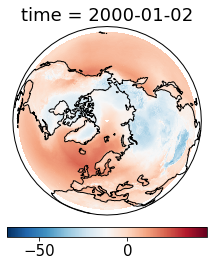

In [212]:
ax = plt.axes(projection=ccrs.Orthographic(20, 90))
t_ref_test.isel(time=0).plot.pcolormesh(ax=ax,
                                      cmap='RdBu_r',
                                      vmax=int(t_test.max()),
                                      vmin=int(t_test.min()),
                                      transform=ccrs.PlateCarree(),
                                      extend='neither',
                                      cbar_kwargs={'orientation': 'horizontal',
                                                  'pad': 0.05,
                                                  'shrink': 0.5,
                                                  'spacing': 'proportional'
                                                 }
                         )
plt.tight_layout()
ax.set_global()
ax.coastlines()

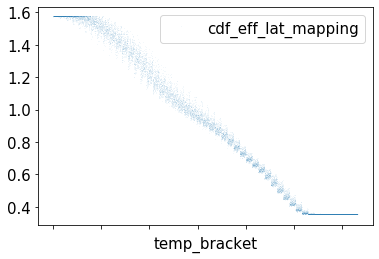

In [128]:
area_weights.plot(x='temp_bracket', y ='cdf_eff_lat_mapping', linestyle='', marker=',', alpha=.05)

In [110]:
t_df_test.head()

,latitude,longitude,time,t2m,area_grid,temp_bracket
0,90.0,0.0,1980-12-07,245.146805,-0.000034,245
1,90.0,0.0,1980-12-14,247.610977,-0.000034,247
2,90.0,0.0,1980-12-21,249.565994,-0.000034,249
3,90.0,0.0,1980-12-28,242.002106,-0.000034,241
4,90.0,0.0,1981-01-04,245.176544,-0.000034,245


In [172]:
ddf_merge = t_df_test.merge(test, on=['time', 'temp_bracket'], how='inner').compute()

print(ddf_merge.shape)
ef_lat_group = ddf_merge['eff_lat_deg']
temp_brackets = ddf_merge['temp_bracket']

# Interpolate to calculate the t_ref latitde mapping
t_ref = np.interp(ddf_merge['latitude'],
                  np.flip(ef_lat_group),
                  np.flip(temp_brackets)
                 )

(12499200, 9)


In [ ]:
for p in range(t_df_test.npartitions):
    print(len(t_df_test.get_partition(p)))

In [148]:
t_df_test

,latitude,longitude,time,t2m,area_grid,temp_bracket
npartitions=280,,,,,,
0,float32,float32,datetime64[ns],float32,float32,int64
751680,...,...,...,...,...,...
...,...,...,...,...,...,...
209718720,...,...,...,...,...,...
210470399,...,...,...,...,...,...


In [176]:
#t_max, t_min = dask.compute(t_df_test['t2m'].max(), t_df_test['t2m'].min())
#range_cuts = range(int(t_min), int(t_max + 10), 2)
#t_df_test['temp_bracket'] = t_df_test['t2m'].map_partitions(
#        pd.cut, range_cuts
#    )
#t_df_test['temp_bracket'] = t_df_test.temp_bracket.apply(lambda x: x.left,
#                                               meta=('temp_bracket', 'str')).astype(int)

test_p = t_df_test.map_partitions(temp_ref,
                                  area_weights=test,
                                  temp_binedges='temp_bracket',
                                  pdf_lat_effs='eff_lat_deg',
                                  meta={'t_ref': float})

In [177]:
t_df_test['tref'] = pd.Series(test_p.compute())

In [179]:
t_df_test['t_prime'] = t_df_test['t2m'] - t_df_test['tref']

In [180]:
t_df_test.head(10)

,latitude,longitude,time,t2m,area_grid,temp_bracket,tref,t_prime
0,90.0,0.0,1980-12-07,245.146805,-0.000034,245,245.0,0.146805
1,90.0,0.0,1980-12-14,247.610977,-0.000034,247,245.0,2.610977
2,90.0,0.0,1980-12-21,249.565994,-0.000034,249,245.0,4.565994
3,90.0,0.0,1980-12-28,242.002106,-0.000034,241,245.0,-2.997894
4,90.0,0.0,1981-01-04,245.176544,-0.000034,245,245.0,0.176544
5,90.0,0.0,1981-01-11,245.263702,-0.000034,245,245.0,0.263702
6,90.0,0.0,1981-01-18,242.455978,-0.000034,241,245.0,-2.544022
7,90.0,0.0,1981-01-25,246.165634,-0.000034,245,245.0,1.165634
8,90.0,0.0,1981-02-01,251.295547,-0.000034,251,245.0,6.295547
9,90.0,0.0,1981-02-08,249.304214,-0.000034,249,245.0,4.304214


In [77]:
t_max, t_min = dask.compute(t_df['t2m'].max(), t_df['t2m'].min())
range_cuts = range(int(t_min), int(t_max + 10), 2)
t_df['temp_bracket'] = t_df['t2m'].map_partitions(
        pd.cut, range_cuts
    )
t_df['temp_bracket'] = t_df.temp_bracket.apply(lambda x: x.left,
                                               meta=('temp_bracket', 'str')).astype(int)
t_df

,latitude,longitude,time,t2m,temp_bracket
npartitions=280,,,,,
0,float32,float32,datetime64[ns],float32,int64
751680,...,...,...,...,...
...,...,...,...,...,...
209718720,...,...,...,...,...
210470399,...,...,...,...,...


In [47]:
t_df_merge = t_df_test.merge(test, how='inner', on=['temp_bracket', 'time'])
result = t_df_merge.compute()
result

,latitude,longitude,time,t2m,area_grid_x,temp_bracket,area_grid_y,cdf_eff_lat_mapping,eff_lat_deg
0,90.00,0.00,1980-12-07,245.146805,-0.000034,245,15288396.0,1.222591,70.049301
1,90.00,0.25,1980-12-07,245.146805,-0.000034,245,15288396.0,1.222591,70.049301
2,90.00,0.50,1980-12-07,245.146805,-0.000034,245,15288396.0,1.222591,70.049301
3,90.00,0.75,1980-12-07,245.146805,-0.000034,245,15288396.0,1.222591,70.049301
4,90.00,1.00,1980-12-07,245.146805,-0.000034,245,15288396.0,1.222591,70.049301
...,...,...,...,...,...,...,...,...,...
44635,20.25,261.50,1990-02-18,284.948730,724.202454,283,107313400.0,0.617195,35.362648
44636,20.25,261.50,1990-12-09,280.685608,724.202454,279,90913528.0,0.698574,40.025318
44637,20.25,261.75,1990-12-09,280.984283,724.202454,279,90913528.0,0.698574,40.025318
44638,20.25,261.50,1990-12-23,284.888000,724.202454,283,107594752.0,0.615841,35.285088


In [ ]:
result.to_csv('~/reanalysis_getter/merge_df_eff_lat.csv', index=False)

In [140]:
b = result.groupby('time', group_keys=False).apply(temp_ref, 
                                                   temp_binedges='temp_bracket',
                                                   pdf_lat_effs='eff_lat_deg')

TypeError: temp_ref() missing 1 required positional argument: 'area_weights'

In [ ]:
b.iloc[0].shape

In [ ]:
test_no_zero = test[test['area_grid'] > 0]
#test_no_zero['temp_bracket'] = test_no_zero.temp_bracket.apply(lambda x: x.left)
test_no_zero = test_no_zero.sort_values(['time', 'temp_bracket'])

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="temp_bracket", 
             y="area_grid", 
             hue='time',
             legend=False,
             palette=sns.color_palette("mako_r", len(test_no_zero.time.unique())),
             data=test_no_zero)
ax.set(xlabel='Temp Bracket (K)', ylabel='CDF Area')
plt.xticks(rotation='vertical')
plt.yscale('log')

In [ ]:
ds_week_df_times['area_grid'] = ds_week_df_times.latitude.apply(lambda x: fancy_area(x))

In [ ]:
# Make cut-offs with 12-hours (more spread)
cut_off = pd.interval_range(start=int(min(ds_week_df_times.t2m)), 
                            end=int(max(ds_week_df_times.t2m)) + 5, 
                            freq=5)

ds_week_df_times = ds_week_df_times.assign(temp_bracket=pd.cut(ds_week_df_times['t2m'], 
                                                               cut_off, 
                                                               right=True))

In [ ]:
# Save data for Amanda
t_df.to_csv('t2m_temp_1207_0208.csv',index=False)

In [ ]:
# Calculate count of grids per group: time and temperature range
ds_week_df_north_group = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)[['latitude']].\
count().\
rename(columns = {'latitude': 'number_grids'})

ds_week_df_north_group = ds_week_df_north_group.assign(
    number_grids_cumsum = ds_week_df_north_group.number_grids.cumsum(),
    left_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.right)
)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="number_grids_cumsum", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group)
sns.lineplot(x="left_temp_interval", 
             y="number_grids",
             palette=sns.color_palette("BuGn", 14),
             data=ds_week_df_north_group,
             ax=ax,
             legend=False)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')
plt.yscale('log')

###  Calculate weekly temperature bucket covered area in the northern hemisphere [$latitude > 20$]

In [ ]:
# Calculate sum of grid area per group: time and temperature range
ds_week_df_north_group_area = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)['area_grid'].\
sum().\
rename(columns = {'area_grid': 'total_area_grid'})

# There must be a better way of doing this (maybe .agg method?)
ds_week_df_north_group_area['grids_cumsum_area'] = ds_week_df_north_group_area.\
groupby('time').\
total_area_grid.\
cumsum()

ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    left_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.right)
)